In [58]:
# Import necessary libraries
import numpy as np
import pandas as pd
from dowhy import CausalModel

from econml.iv.dml import OrthoIV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from causalml.inference.iv import IVRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression

Identified estimand:
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                          
───────────────(E[purchaseₐₘₒᵤₙₜ])
d[email_opened]                   
Estimand assumption 1, Unconfoundedness: If U→{email_opened} and U→purchase_amount then P(purchase_amount|email_opened,,U) = P(purchase_amount|email_opened,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                         -1⎤
 ⎢         d                          ⎛         d                         ⎞  ⎥
E⎢───────────────────(purchaseₐₘₒᵤₙₜ)⋅⎜───────────────────([email_opened])⎟  ⎥
 ⎣d[email_assignment]                 ⎝d[email_assignment]                ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→purchase_amount then ¬(U →→{email_assignment})
Estimand assumption 2, Exclusion: If we remove {email_assignment}→{email_opened}, then ¬({email_assignment}→purchase_amount)

### Estimand : 3
Estimand name:

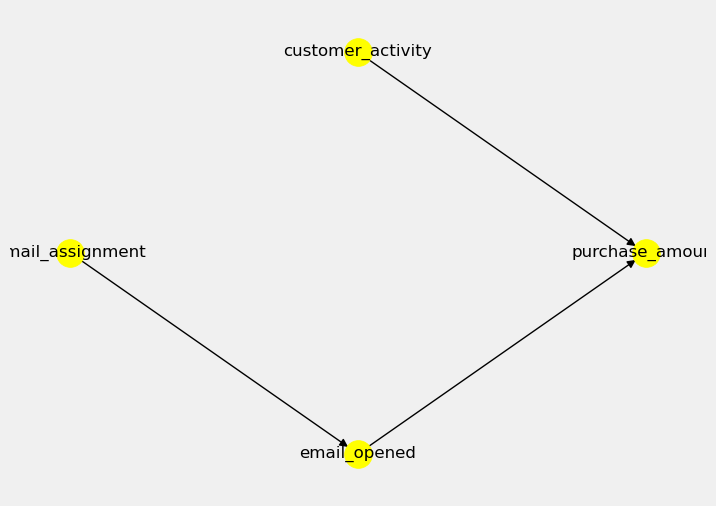

In [59]:
# For reproducibility
np.random.seed(42)

# -----------------------------
# Step 1: Simulate the A/B Test Dataset
# -----------------------------
n = 2000  # Number of users in experiment

# Simulate random assignment (A/B test groups)
# Group A: Received product recommendation email (treatment group)
# Group B: Did not receive email (control group)
email_assignment = np.random.binomial(1, 0.5, n)  # 50% chance to be in Group A

# Simulate email opening behavior (non-compliance):
# - 30% of Group A opens the email (compliers)
# - Group B cannot open the email (exclusion restriction)
email_opened = np.where(
    email_assignment == 1,
    np.random.binomial(1, 0.3, n),  # Only 30% compliance in treatment group
    np.zeros(n)  # Control group cannot open non-existing email
)

# Simulate baseline purchase amount (pre-existing customer behavior)
baseline_purchase = np.random.normal(80, 15, n)  # Average $80 purchase

# Create treatment effect:
# - Opening email increases purchase by $15 on average
# - Add noise to simulate real-world variability
purchase_amount = baseline_purchase + email_opened * 15 + np.random.normal(0, 8, n)

# Add customer activity score (covariate)
customer_activity = np.random.normal(6, 1.5, n)  # Weekly site visits

# Create DataFrame
df = pd.DataFrame({
    "email_assignment": email_assignment,  # Instrument (A/B group assignment)
    "email_opened": email_opened.astype(int),  # Actual treatment received
    "purchase_amount": purchase_amount,     # Outcome metric
    "customer_activity": customer_activity  # Pre-existing customer characteristic
})

# -----------------------------
# Step 2: Define Causal Model
# -----------------------------
causal_graph = """
digraph {
    email_assignment -> email_opened;
    email_opened -> purchase_amount;
    customer_activity -> purchase_amount;
}
"""

model = CausalModel(
    data=df,
    treatment="email_opened",
    outcome="purchase_amount",
    graph=causal_graph
)


# Visualize the causal graph (optional)
model.view_model()


# -----------------------------
# Step 3: Identify and Estimate CACE
# -----------------------------
# Identify the causal effect using DoWhy. For IV estimation, we rely on the instrument 'assignment'
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print("Identified estimand:")
print(identified_estimand)
iv_estimate = model.estimate_effect(
    identified_estimand,
    method_name="iv.instrumental_variable",
    method_params={"iv_instrument_name": "email_assignment"}
)

print("CACE Estimate:", iv_estimate.value)

# -----------------------------
# Step 4: Manual IV Verification
# -----------------------------
# Calculate manually: (E[Y|Z=1] - E[Y|Z=0]) / (E[T|Z=1] - E[T|Z=0])
y1 = df[df.email_assignment == 1].purchase_amount.mean()
y0 = df[df.email_assignment == 0].purchase_amount.mean()
t1 = df[df.email_assignment == 1].email_opened.mean()
t0 = df[df.email_assignment == 0].email_opened.mean()

manual_cace = (y1 - y0) / (t1 - t0)
print("Manual CACE Calculation:", manual_cace)


In [60]:
# EconML implementation
X = df[["customer_activity"]]
T = df["email_opened"]
Z = df["email_assignment"]
Y = df["purchase_amount"]

# Correct parameter names (lowercase convention)
model = OrthoIV(
    # model_y_xw=RandomForestRegressor(), # Outcome model
    # model_t_xw=RandomForestRegressor(), # Treatment model
    # model_z_xw=RandomForestRegressor(), # Instrument model
    model_y_xw=AdaBoostRegressor(), # Outcome model
    model_t_xw=AdaBoostRegressor(), # Treatment model
    model_z_xw=AdaBoostRegressor(), # Instrument model
    discrete_treatment=True,    # Treatment is binary
    discrete_instrument=True,  # Instrument is binary
)

model.fit(Y, T, Z=Z, X=X)
cace = model.const_marginal_effect(X).mean() # Average CACE
print(f"CACE Estimate (EconML): {cace:.2f}")

CACE Estimate (EconML): 15.37


First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!


In [61]:
# CausalML IV Regression implementation
# Format data for Two-Stage Least-Squares (IV2SLS) model (per library documentation)
iv_model = IVRegressor()

# Split data components as required by the library's fit() method
X = df[["customer_activity"]]      # Covariates
treatment = df["email_opened"]      # Endogenous treatment
y = df["purchase_amount"]           # Outcome
w = df["email_assignment"]          # Instrument

# Fit model with proper parameter names
iv_model.fit(
    X=X,
    treatment=treatment,
    y=y,
    w=w
)

# Get treatment effect and standard error
cace, se = iv_model.predict()
print(f"CACE Estimate: {cace:.2f} (±{se:.2f})")

CACE Estimate: 14.77 (±2.57)
